## **Walmart Sales Forecast**

**Dicionário de Dados**

* Store - número da loja.
* Date - semana da apuração das vendas.
* Weekly_Sales - quantidade de vendas de uma determinada loja.
* Holiday_Flag - 1 se for feriado; 0 caso contrário.
* Temperature - Temperatura na semana de apuração na região da loja
* Fuel_Price - Preço do combustível na região da loja, dados monetários em dólar.
* CPI – Consumer Price Index, índice de inflação ao consumidor na região da loja.
* Unemployment - Taxa de desemprego na região da loja.

**OBJETIVO DA MODELAGEM:** prever as vendas semanais do Walmart, dado o conjunto de dados disponível.

A ideia do time de negócio é utilizar o modelo para planejar ações como estoque e prospectar demanda. Além disso, objetiva-se compreender melhor a inserção e perfil da empresa e suas filiais.

### Nota:
Provavelmente esta é a origem dos dados: https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data

In [1]:
# imports
# manipulação de dados
import pandas as pd
import numpy as np

# visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# configuração de warnings
import warnings
#warnings.filterwarnings('ignore')

In [2]:
# leitura da base
df = pd.read_csv('Walmart.csv')
# inspeção da base
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
df.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667
6434,45,26-10-2012,760281.43,0,58.85,3.882,192.308899,8.667


Os dados estão ordenados primeiro pelo número das lojas, depois pela semana, identificada pela data, sempre às sextas-feiras.  
Ainda não entendi como funciona `Holiday_Flag`.  

In [4]:
# dtype de cada coluna
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [5]:
# converte a coluna Date para o formato datetime
df['Date'] = pd.to_datetime(df.Date, format='%d-%m-%Y')
# ordena a base de dados pelas colunas de Data e Vendas
df = (
    df
     .sort_values(
        by=['Date', 'Weekly_Sales'],
        ascending=True)
     .reset_index(drop=True)
)

In [6]:
# verifica missing values
# conclusão: não há missing values
print("Missing Values:")
print(df.isna().sum())
# verifica linhas duplicadas
# conclusão: não há linhas duplicadas
print("-----------------")
print("Número de linhas duplicadas: ", df.duplicated().sum())

Missing Values:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64
-----------------
Número de linhas duplicadas:  0


In [7]:
# quantidade de valores únicos em cada coluna
# Conclusões:
# 1. Holiday_Flag de fato é uma dummy
# 2. Temos 45 lojas
df.nunique().sort_values()

Holiday_Flag       2
Store             45
Date             143
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [8]:
# sumário estatístico
# conclusão: não identificamos nenhuma variável inconsistente (venda negativa, por exemplo)
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [9]:
# cria colunas a partir da data
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year
df.head(2)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year
0,33,2010-02-05,274593.43,0,58.40,2.962,126.442065,10.115,2,2010
1,44,2010-02-05,281090.95,0,31.53,2.666,126.442065,8.119,2,2010


In [10]:
datas = df.copy()

In [11]:
# no homework teste as seguintes possibilidades:
datas['dayofweek'] = datas.Date.dt.dayofweek
datas['day_name'] = datas.Date.dt.day_name()
datas['is_month_start'] = datas.Date.dt.is_month_start.map({True:1, False:0})
datas['is_month_end'] = datas.Date.dt.is_month_end.map({True:1, False:0})
datas['days_in_month'] = datas.Date.dt.days_in_month
datas['is_quarter_start'] = datas.Date.dt.is_quarter_start.map({True:1, False:0})
datas['is_quarter_end'] = datas.Date.dt.is_quarter_end.map({True:1, False:0})

In [12]:
datas.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year,dayofweek,day_name,is_month_start,is_month_end,days_in_month,is_quarter_start,is_quarter_end
0,33,2010-02-05,274593.43,0,58.40,2.962,126.442065,10.115,2,2010,4,Friday,0,0,28,0,0
1,44,2010-02-05,281090.95,0,31.53,2.666,126.442065,8.119,2,2010,4,Friday,0,0,28,0,0
2,5,2010-02-05,317173.10,0,39.70,2.572,211.653972,6.566,2,2010,4,Friday,0,0,28,0,0
3,38,2010-02-05,358496.14,0,49.47,2.962,126.442065,13.975,2,2010,4,Friday,0,0,28,0,0
4,3,2010-02-05,461622.22,0,45.71,2.572,214.424881,7.368,2,2010,4,Friday,0,0,28,0,0


In [13]:
datas.tail()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year,dayofweek,day_name,is_month_start,is_month_end,days_in_month,is_quarter_start,is_quarter_end
6430,10,2012-10-26,1744349.05,0,70.50,4.301,131.193097,6.943,10,2012,4,Friday,0,0,31,0,0
6431,2,2012-10-26,1834458.35,0,69.79,3.506,223.078337,6.170,10,2012,4,Friday,0,0,31,0,0
6432,20,2012-10-26,2031650.55,0,60.04,3.882,216.151590,7.293,10,2012,4,Friday,0,0,31,0,0
6433,13,2012-10-26,2035189.66,0,46.97,3.755,131.193097,5.621,10,2012,4,Friday,0,0,31,0,0
6434,4,2012-10-26,2149594.46,0,63.64,3.514,131.193097,3.879,10,2012,4,Friday,0,0,31,0,0


In [14]:
datas['day_name'].unique()

array(['Friday'], dtype=object)

No link acima do kaggle fala sobre `Holiday_Flag`:  

    IsHoliday - whether the week is a special holiday week  

    For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):  

    Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13  
    Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13  
    Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13  
    Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13  

#### Verificando as informações sobre lojas

In [15]:
lojas = df['Store'].unique()
print(np.sort(lojas))
print(len(lojas))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
45


In [16]:
vendas_por_loja = df.groupby('Store')[['Weekly_Sales']].sum()
vendas_por_loja['Weekly_Sales'] = vendas_por_loja['Weekly_Sales']/1000000
vendas_por_loja.sort_values(by=['Weekly_Sales'], inplace=True, ascending=False)
vendas_por_loja

,Weekly_Sales
Store,
20,301.397792
4,299.543953
14,288.999911
13,286.517704
2,275.382441
10,271.617714
27,253.855917
6,223.756131
1,222.402809


In [17]:
# relação entre vendas da loja que vende mais e da que vende menos
print(round(vendas_por_loja.max()['Weekly_Sales']/vendas_por_loja.min()['Weekly_Sales'], 2))

8.11


In [18]:
# identificando a loja com maior venda
loja_max = vendas_por_loja.idxmax().iloc[0]
loja_max

20

In [19]:
vendas_por_loja.median()
#teste = vendas_por_loja.median()
#teste.index[0]
#como encontrar o índice do elemento mediano?
# manualmente: loja 34

Weekly_Sales    138.249763
dtype: float64

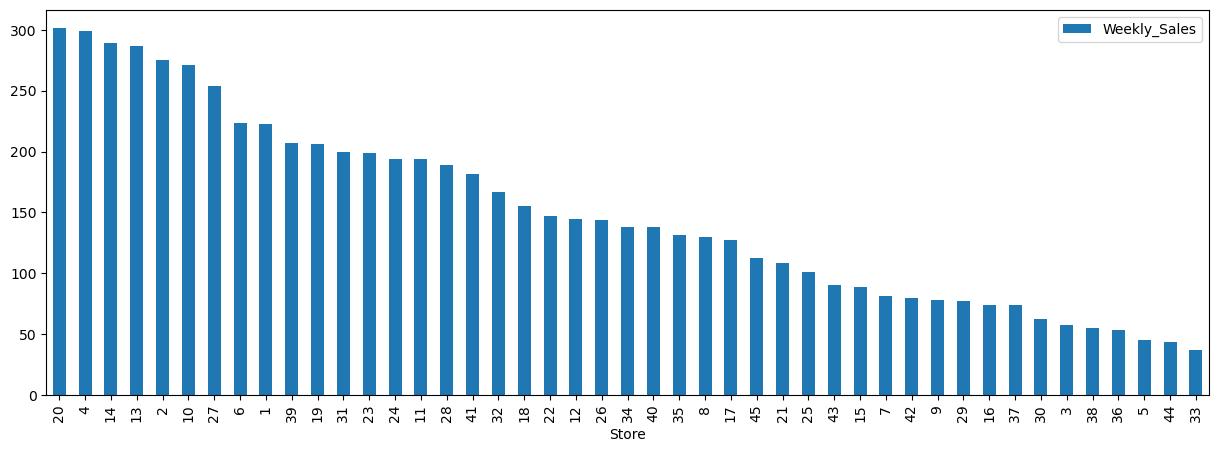

In [20]:
vendas_por_loja.plot.bar(figsize=(15, 5));

### Análise
As vendas tem uma distribuição razoável pelas lojas. Não há lojas que se destaquem por muitas ou poucas vendas.

## Análise Exploratória de Dados
Nesta etapa estamos interessados em compreender melhor os dados por meio de técnicas de visualização de dados.

In [21]:
# cria um data frame mensal (aplicando-se média)
month_data = df.set_index('Date')\
    .resample('m')[['Weekly_Sales', 'CPI', 'Unemployment']]\
    .mean()

month_data.head()

,Weekly_Sales,CPI,Unemployment
Date,,,
2010-02-28,1.057405e+06,167.834459,8.619311
2010-03-31,1.010666e+06,167.930846,8.619311
2010-04-30,1.028499e+06,167.678437,8.497711
2010-05-31,1.037283e+06,167.641758,8.497711
2010-06-30,1.068034e+06,168.004688,8.497711


#### Evolução das vendas e outras variáveis no tempo

In [22]:
# cria figura e eixo
def plot_line_month_data(feature, title, ylabel):
    fig, ax = plt.subplots(figsize=(10, 4))
    # cálculo das vendas médias mensais
    month_data[feature].plot(ax=ax, color='black', linewidth=2)
    # labels
    # título
    plt.title(title, fontweight='bold', pad=15)
    # rótulo do eixo x
    plt.xlabel('')
    # rótulo do eixo y
    plt.ylabel(ylabel)
    # oculta spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

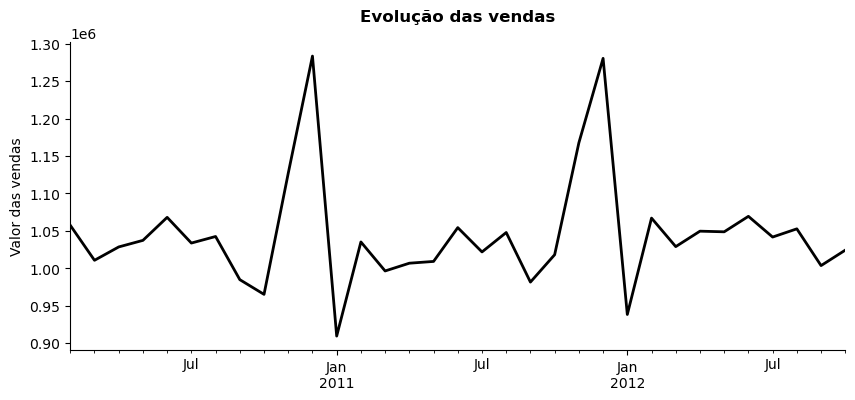

In [23]:
plot_line_month_data(
    'Weekly_Sales', 
    'Evolução das vendas', 
    'Valor das vendas'
)

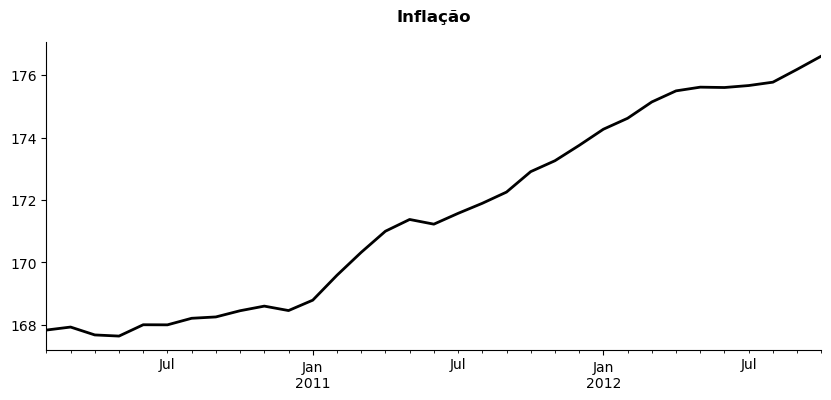

In [24]:
plot_line_month_data(
    'CPI', 
    'Inflação', 
    ''
)

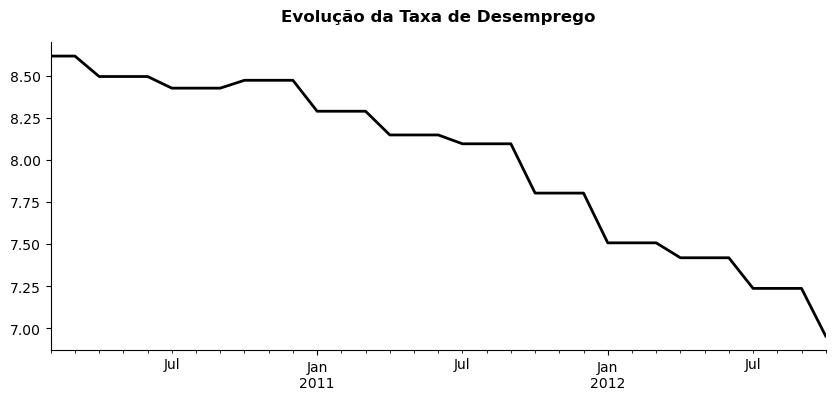

In [25]:
plot_line_month_data(
    'Unemployment', 
    'Evolução da Taxa de Desemprego', 
    ''
)

In [26]:
def plot_two_axes(variavel_eixo_1, variavel_eixo_2, title):
    # cria figura e eixo
    fig, ax1 = plt.subplots(figsize=(8, 5))
    # título
    fig.suptitle(title, fontweight='bold')
    # eixo 1
    month_data[variavel_eixo_1].plot(ax=ax1, color='black', linewidth=2)
    ax1.set_ylabel(variavel_eixo_1)

    # cria segundo eixo
    ax2 = ax1.twinx()
    month_data[variavel_eixo_2].plot(ax=ax2, color='lightgray', linewidth=2)
    ax2.set_ylabel(variavel_eixo_2)
    
    # adiciona legenda
    fig.legend()
    plt.show()

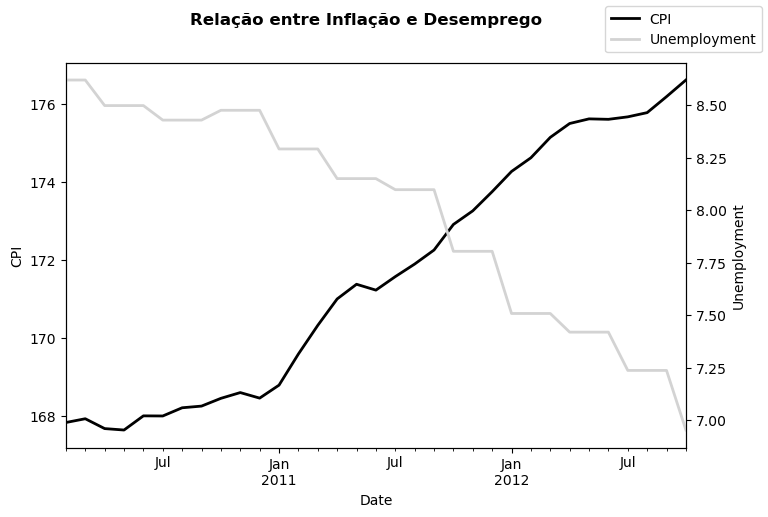

In [27]:
plot_two_axes(
    'CPI', 
    'Unemployment', 
    'Relação entre Inflação e Desemprego'
)

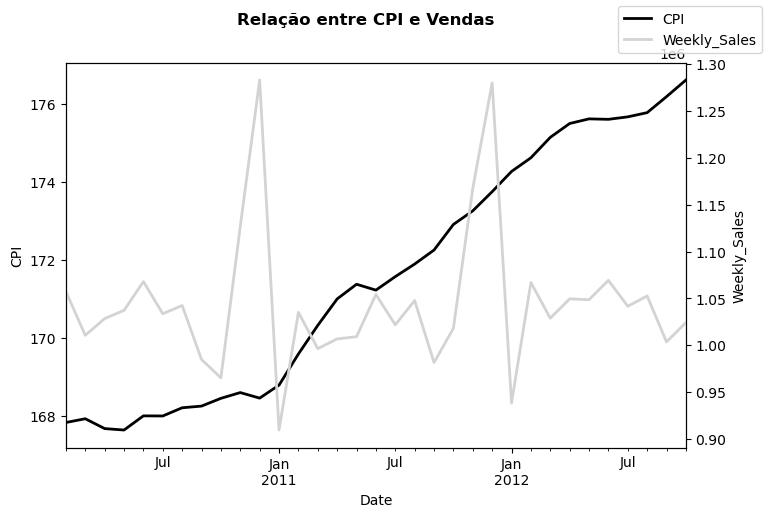

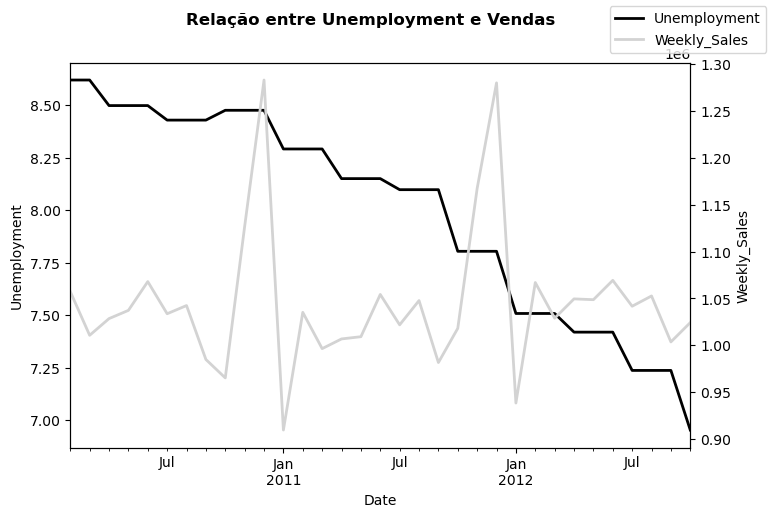

In [28]:
for feature in ['CPI', 'Unemployment']:
    plot_two_axes(
        feature,
        'Weekly_Sales',
        f'Relação entre {feature} e Vendas'
    )

#### Análise estatística

In [29]:
# lista com colunas numéricas
num_cols = df.select_dtypes(include='number').columns.tolist()

/home/fagmj/miniconda3/envs/viking/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


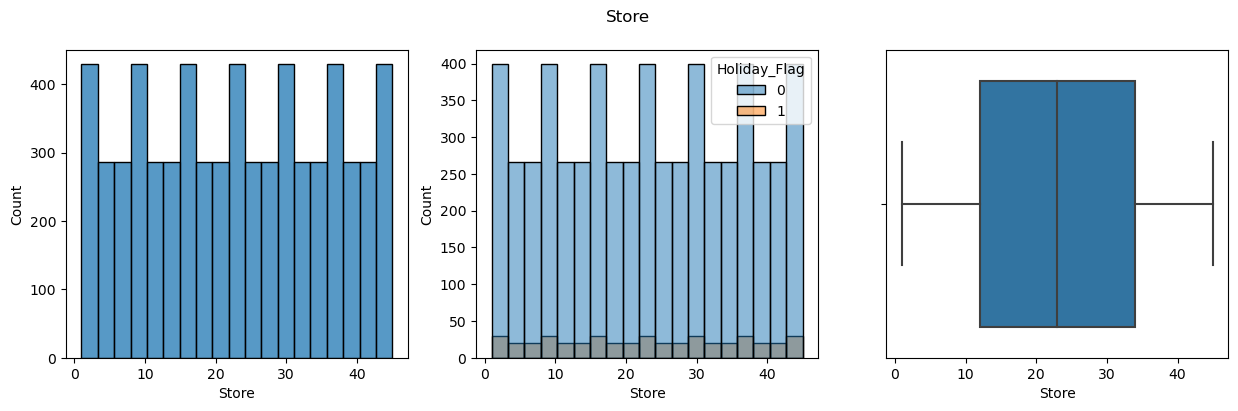

/home/fagmj/miniconda3/envs/viking/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


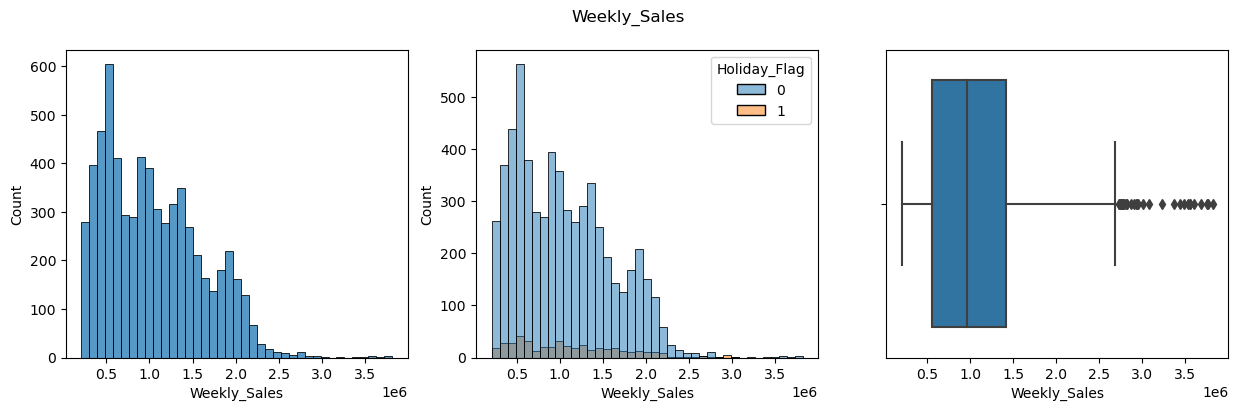

/home/fagmj/miniconda3/envs/viking/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


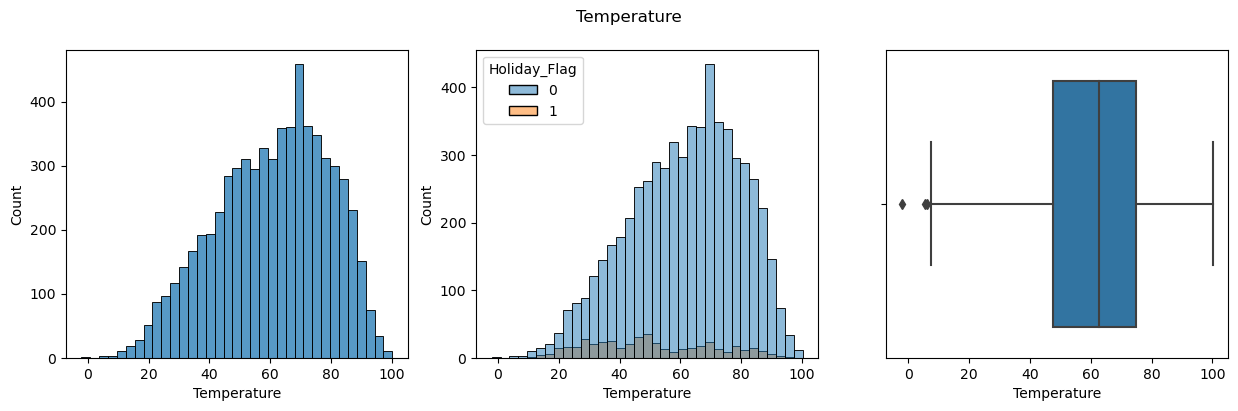

/home/fagmj/miniconda3/envs/viking/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


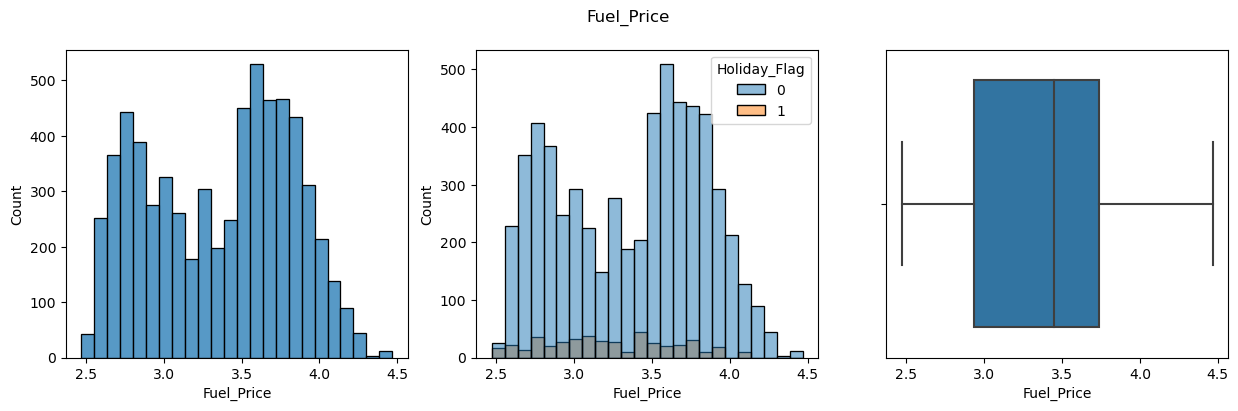

/home/fagmj/miniconda3/envs/viking/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


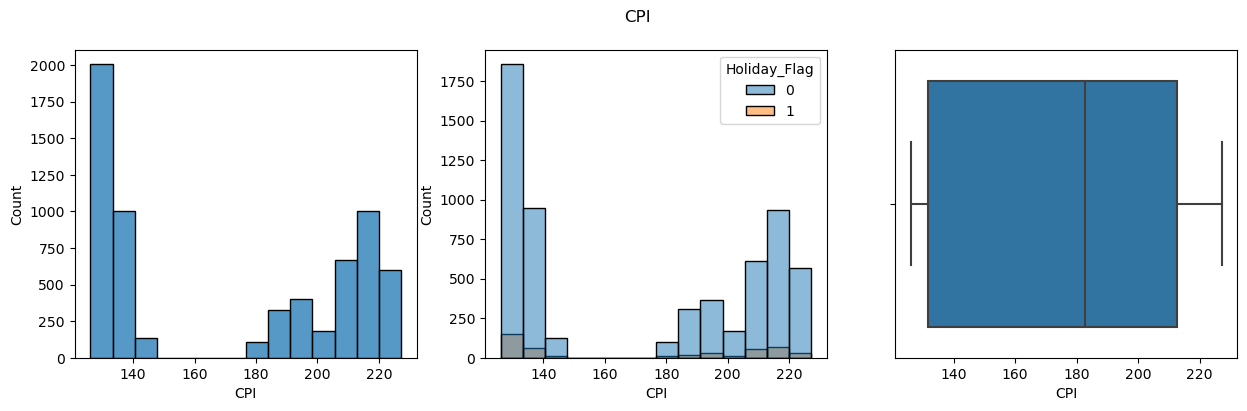

/home/fagmj/miniconda3/envs/viking/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


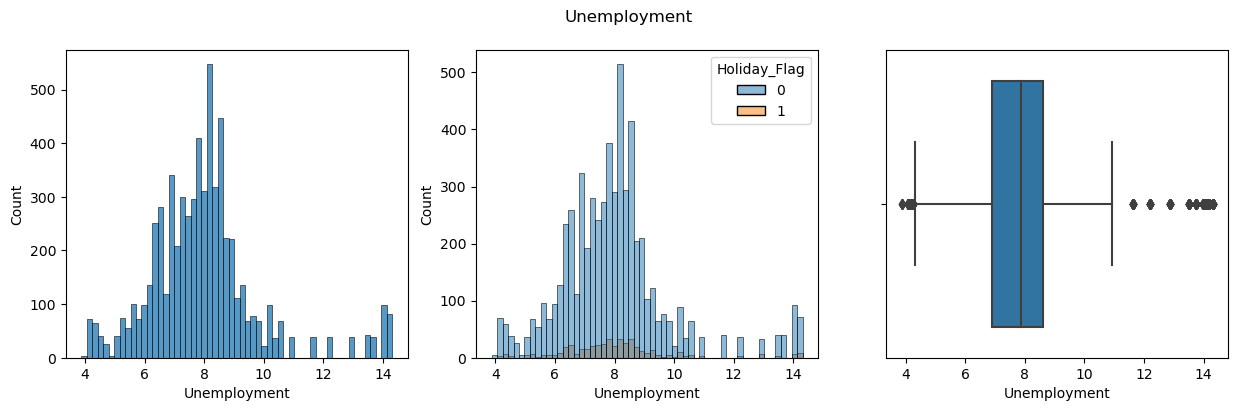

/home/fagmj/miniconda3/envs/viking/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


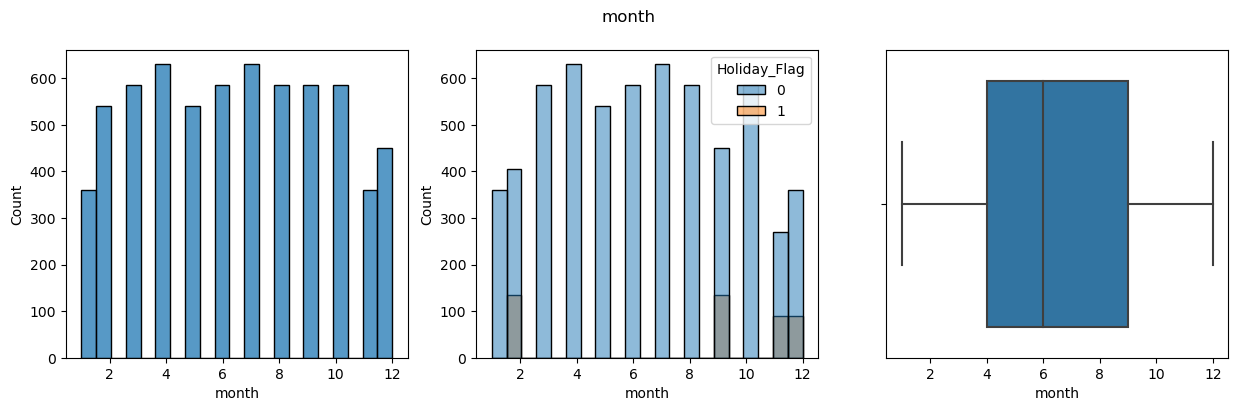

/home/fagmj/miniconda3/envs/viking/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


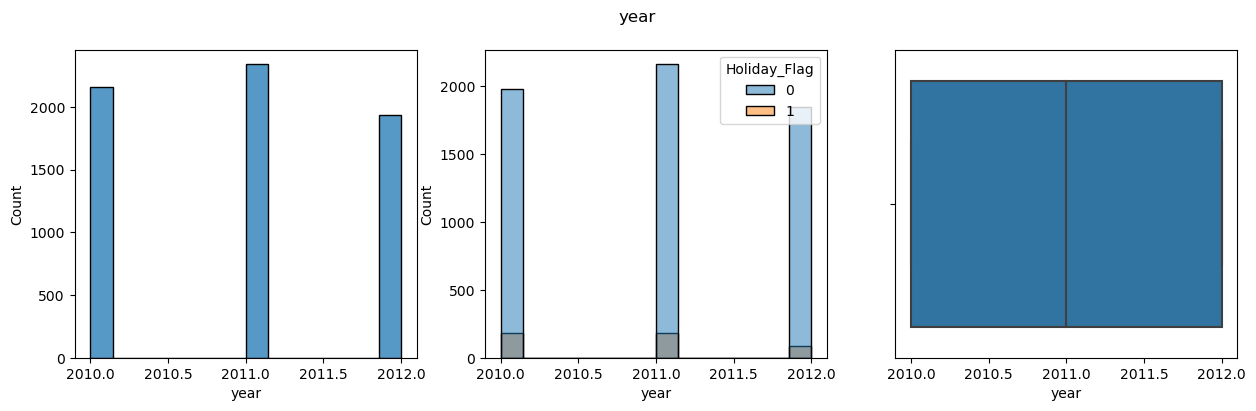

In [30]:
for feature in num_cols:
    #  se a variável for igual a 'Holiday_Flag' pula o laço
    if feature == 'Holiday_Flag':
        continue
    # cria figura e eixo
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(feature)
    # histograma
    sns.histplot(df[feature], ax=ax[0])
    sns.histplot(x=feature, ax=ax[1], data=df, hue='Holiday_Flag')
    # boxplot
    sns.boxplot(df[feature], orient='h', ax=ax[2])
    plt.show()

In [31]:
#sns.pairplot(data=df, diag_kind='kde');

In [32]:
corr = df.corr()
corr

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year
Store,1.000000e+00,-0.335332,1.812536e-16,-0.022659,0.060023,-0.209492,0.223531,3.281056e-16,4.262914e-15
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176,7.614332e-02,-1.837754e-02
Holiday_Flag,1.812536e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960,1.229958e-01,-5.678257e-02
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158,2.358618e-01,6.426923e-02
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684,-4.215590e-02,7.794703e-01
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020,4.979672e-03,7.479573e-02
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000,-1.274559e-02,-2.418135e-01
month,3.281056e-16,0.076143,1.229958e-01,0.235862,-0.042156,0.004980,-0.012746,1.000000e+00,-1.944645e-01
year,4.262914e-15,-0.018378,-5.678257e-02,0.064269,0.779470,0.074796,-0.241813,-1.944645e-01,1.000000e+00


In [33]:
#print(corr.max())
#print(corr.min())

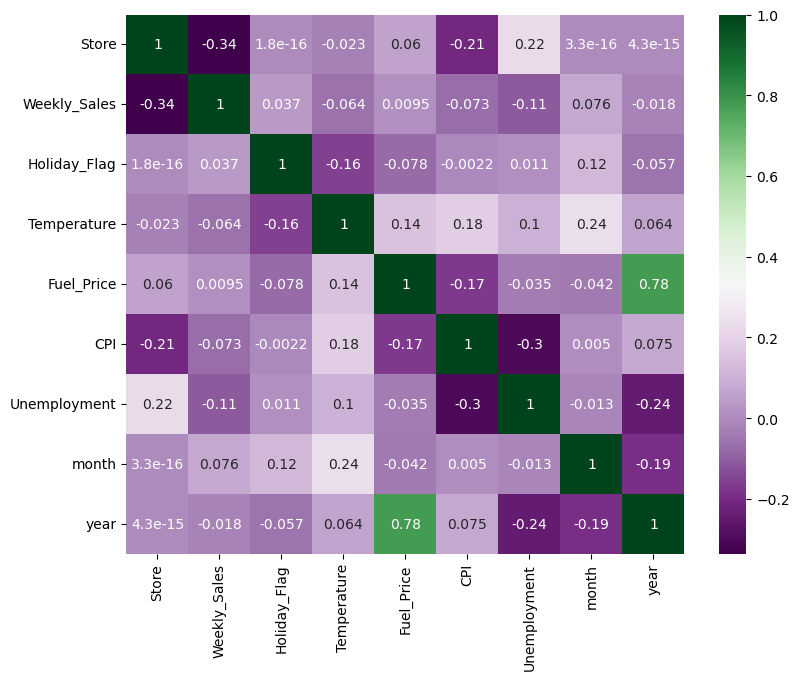

In [34]:
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr, cmap="PRGn", annot=True);
#sns.heatmap(corr, cmap=sns.color_palette("vlag"), linewidths=.5, annot=True, center= 0, vmin=-1, vmax=1);

# Regressão linear
Inicialmente vou analisar os dados de uma loja e depois verificar o total.  
Conforme comentado acima, vou escolher a loja de número 34.  

In [35]:
loja_34 = df[df['Store']==34].copy()
loja_34.head(2)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year
19,34,2010-02-05,956228.96,0,35.44,2.598,126.442065,9.521,2,2010
65,34,2010-02-12,994610.99,1,36.13,2.573,126.496258,9.521,2,2010


In [36]:
loja_34.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 19 to 6412
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         143 non-null    int64         
 1   Date          143 non-null    datetime64[ns]
 2   Weekly_Sales  143 non-null    float64       
 3   Holiday_Flag  143 non-null    int64         
 4   Temperature   143 non-null    float64       
 5   Fuel_Price    143 non-null    float64       
 6   CPI           143 non-null    float64       
 7   Unemployment  143 non-null    float64       
 8   month         143 non-null    int64         
 9   year          143 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 12.3 KB


In [37]:
loja_34.drop(columns=['Store', 'Date', 'month', 'year'], inplace=True)
loja_34.head(2)

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
19,956228.96,0,35.44,2.598,126.442065,9.521
65,994610.99,1,36.13,2.573,126.496258,9.521


### Regressão linear simples

In [38]:
# verificar o uso de reshape
# define a feature do modelo
X1 = loja_34['CPI'].values.reshape(-1,1)
# define a target do modelo
y1 = loja_34['Weekly_Sales'].values.reshape(-1,1)

In [39]:
# separa os dados em treino e teste
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=1, test_size=0.3)

In [40]:
# instancia o modelo
linear_model1 = LinearRegression()
# treina o modelo
linear_model1.fit(X1_train, y1_train)

LinearRegression()

In [41]:
# intercepto do modelo
print(linear_model1.intercept_)
# parâmetro de inclinação
print(linear_model1.coef_)

[15864.68119149]
[[7315.9796421]]


In [42]:
# previsões do modelo
y1_pred = linear_model1.predict(X1_train)
# resíduo do modelo (diferença entre o valor real e o valor ajustado)
resid = y1_train - y1_pred

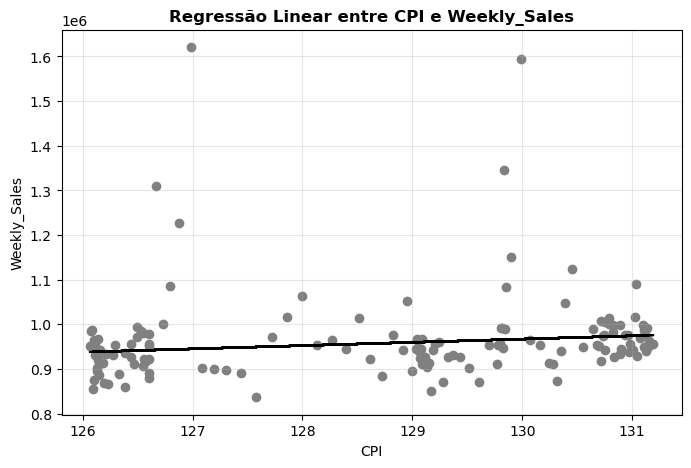

In [43]:
# ajusta tamanho da figura
plt.figure(figsize=(8, 5))
# scatter plot
plt.scatter('CPI', 'Weekly_Sales', data=loja_34, color='gray')
# modelo
plt.plot(X1_train, y1_pred, color='black')
# labels
plt.title('Regressão Linear entre CPI e Weekly_Sales', fontweight='bold')
plt.xlabel('CPI')
plt.ylabel('Weekly_Sales')
# configura gridlines
plt.grid(alpha=0.3)
plt.show()

#### Avaliando o modelo no conjunto de teste

In [44]:
# previsão com os dados de treino
y1_pred_train = linear_model1.predict(X1_train)
# previsão com os dados de teste
y1_pred_test = linear_model1.predict(X1_test)

In [45]:
# define uma função para calcular o rmse
def rmse(y1_true, y1_pred):
    "Calcula o RMSE."
    return round(sqrt(mean_squared_error(y1_true, y1_pred)), 2)

In [46]:
# métrica nos dados de treino
rmse(y1_train, y1_pred_train)

91844.07

In [47]:
# métrica nos dados de teste
rmse(y1_test, y1_pred_test)

127910.04

In [48]:
# métrica nos dados de treino
linear_model1.score(X1_train, y1_train)

0.02080154312013427

In [49]:
# métrica nos dados de teste
linear_model1.score(X1_test, y1_test)

-0.05314776838478097

In [50]:
# cálculo do R² usando diretamente função do Sklearn
r2_train = r2_score(y1_train, y1_pred_train)
r2_test = r2_score(y1_test, y1_pred_test)

In [51]:
# métricas no treino e no teste
r2_train, r2_test

(0.02080154312013427, -0.05314776838478097)

### Regressão linear múltipla

In [52]:
X2 = loja_34.drop(['Weekly_Sales'], axis=1)
y2 = loja_34['Weekly_Sales'].values.reshape(-1,1)

In [53]:
# separa os dados em treino e teste
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=1, test_size=0.3)

In [54]:
# instancia o modelo
linear_model2 = LinearRegression()
# treina o modelo
linear_model2.fit(X2_train, y2_train)

LinearRegression()

#### Erro:
ao fazer inicialmente o *fit* tive esse erro:  
```
TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)
```  
Depois vou perguntar aos professores, agora vou tirar a coluna de data.

In [55]:
# intercepto do modelo
print(linear_model2.intercept_)
# parâmetro de inclinação
print(linear_model2.coef_)

[-1252250.41186449]
[[ 85562.17130083   -860.70470553 -42153.32170179  17430.80932764
   14945.93923836]]


In [56]:
# previsões do modelo
y2_pred = linear_model2.predict(X2_train)
# resíduo do modelo (diferença entre o valor real e o valor ajustado)
resid2 = y2_train - y2_pred

Aqui teria que imaginar como fazer um gráfico.

In [57]:
# previsão com os dados de treino
y2_pred_train = linear_model2.predict(X2_train)
# previsão com os dados de teste
y2_pred_test = linear_model2.predict(X2_test)

In [58]:
# define uma função para calcular o rmse
def rmse(y2_true, y2_pred):
    "Calcula o RMSE."
    return round(sqrt(mean_squared_error(y2_true, y2_pred)), 2)

In [59]:
# métrica nos dados de treino
rmse(y2_train, y2_pred_train)

87697.55

In [60]:
# métrica nos dados de teste
rmse(y2_test, y2_pred_test)

118798.88

In [61]:
# métrica nos dados de treino
linear_model2.score(X2_train, y2_train)

0.1072221414335317

In [62]:
# métrica nos dados de teste
linear_model2.score(X2_test, y2_test)

0.09154224346661399

In [63]:
# cálculo do R² usando diretamente função do Sklearn
r2_train2 = r2_score(y2_train, y2_pred_train)
r2_test2 = r2_score(y2_test, y2_pred_test)
# métricas no treino e no teste
r2_train, r2_test

(0.02080154312013427, -0.05314776838478097)

### TESTE tirar semanas de feriados

In [64]:
loja_34_sf = loja_34[loja_34['Holiday_Flag']==0].copy()
loja_34_sf.head(2)

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
19,956228.96,0,35.44,2.598,126.442065,9.521
111,983963.07,0,38.36,2.540,126.526286,9.521


In [65]:
loja_34_sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 19 to 6412
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  133 non-null    float64
 1   Holiday_Flag  133 non-null    int64  
 2   Temperature   133 non-null    float64
 3   Fuel_Price    133 non-null    float64
 4   CPI           133 non-null    float64
 5   Unemployment  133 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 7.3 KB


In [66]:
X3 = loja_34_sf.drop(['Weekly_Sales'], axis=1)
y3 = loja_34_sf['Weekly_Sales'].values.reshape(-1,1)

In [67]:
# separa os dados em treino e teste
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=1, test_size=0.3)

In [68]:
# instancia o modelo
linear_model3 = LinearRegression()
# treina o modelo
linear_model3.fit(X3_train, y3_train)

LinearRegression()

In [69]:
# intercepto do modelo
print(linear_model3.intercept_)
# parâmetro de inclinação
print(linear_model3.coef_)

[-1645000.33049837]
[[     0.          -2110.35712419 -70205.49753831  21051.89476992
   25191.62084196]]


In [70]:
# previsões do modelo
y3_pred = linear_model3.predict(X3_train)
# resíduo do modelo (diferença entre o valor real e o valor ajustado)
resid3 = y3_train - y3_pred

In [71]:
# previsão com os dados de treino
y3_pred_train = linear_model3.predict(X3_train)
# previsão com os dados de teste
y3_pred_test = linear_model3.predict(X3_test)

In [72]:
# define uma função para calcular o rmse
def rmse(y3_true, y3_pred):
    "Calcula o RMSE."
    return round(sqrt(mean_squared_error(y3_true, y3_pred)), 2)

In [73]:
# métrica nos dados de treino
rmse(y3_train, y3_pred_train)

103351.1

In [74]:
# métrica nos dados de teste
rmse(y3_test, y3_pred_test)

62310.78

In [75]:
# métrica nos dados de treino
linear_model3.score(X3_train, y3_train)

0.12439426599298042

In [76]:
# métrica nos dados de teste
linear_model3.score(X3_test, y3_test)

-0.12841917764388122

In [77]:
# cálculo do R² usando diretamente função do Sklearn
r2_train3 = r2_score(y3_train, y3_pred_train)
r2_test3 = r2_score(y3_test, y3_pred_test)
# métricas no treino e no teste
r2_train3, r2_test3

(0.12439426599298042, -0.12841917764388122)

In [78]:
loja_34_sf

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
19,956228.96,0,35.44,2.598,126.442065,9.521
111,983963.07,0,38.36,2.540,126.526286,9.521
158,905756.13,0,37.28,2.590,126.552286,9.521
200,918295.79,0,42.65,2.654,126.578286,9.521
246,921247.88,0,42.26,2.704,126.604286,9.521
...,...,...,...,...,...,...
6232,928629.31,0,67.06,3.666,131.043000,9.285
6275,968896.68,0,65.41,3.620,131.075667,8.839
6322,948613.39,0,59.94,3.603,131.108333,8.839
6368,963516.28,0,58.47,3.610,131.149968,8.839


In [79]:
#scaler = StandardScaler()
#scaler.fit(loja_34_sf)
#escalado = scaler.transform(loja_34_sf)

In [80]:
#escalado